In [2]:
import os
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt

%matplotlib inline

Let's import the skm-tea metadata.csv file.

In [3]:
meta_file_location = "/data/projects/recon/data/public/qdess/v1-release/all_metadata.csv"
metadata = pd.read_csv(meta_file_location, index_col=0)
metadata.head()

,MTR_ID,PatientID,Timepoint,PatientAge,PatientSex,Scanner,Sequence,SliceThickness,SliceSpacing,Is_ZIP2,...,ReconstructionDiameter,ReceiveCoilName,TransmitCoilName,FlipAngle,VariableFlipAngleFlag,SAR,PatientPosition,WindowCenter,WindowWidth,MedialDirection
0,MTR_001,79,0,49,F,2,mfastDessMaps,1.6,0.8,True,...,160,GEM Flex LG Full,NaN,20,N,0.182081,FFS,6533,13066,L
1,MTR_005,99,0,49,M,2,mfastDessMaps,1.6,0.8,True,...,160,HD TR Knee PA,HD TR Knee PA,20,N,0.004215,FFS,1205,2410,R
2,MTR_006,164,0,51,F,2,mfastDessMaps,1.6,0.8,True,...,160,HD TR Knee PA,HD TR Knee PA,20,N,0.005591,FFS,1271,2542,R
3,MTR_008,260,0,61,M,2,mfastDessMaps,1.6,0.8,True,...,160,HD TR Knee PA,HD TR Knee PA,20,N,0.004406,FFS,2422,4844,R
4,MTR_010,165,0,42,M,2,mfastDessMaps,1.6,0.8,True,...,160,HD TR Knee PA,HD TR Knee PA,20,N,0.004580,FFS,1685,3370,R


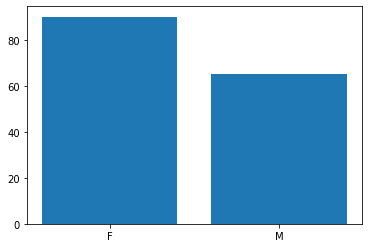

In [4]:

plt.bar(metadata['PatientSex'].unique(), metadata['PatientSex'].value_counts())
plt.show()

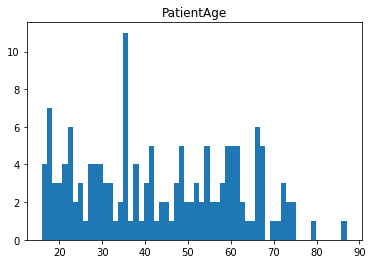

In [5]:
hist = metadata.hist(column='PatientAge', bins=len(metadata['PatientAge'].unique()), grid=False)

In [6]:
print(f"Meganetic Field Stregh is {metadata['MagneticFieldStrength'].unique()[0]}")

Meganetic Field Stregh is 3


Let's now look at the MRI data itself. 

All qDESS data was acquired with 2x1 parallel imaging with elliptical sampling. Missing k-space data was subsequently estimated using ARC (GE) with the GE Orchestra MATLAB SDK. This data is considered the fully-sampled kspace.

In [7]:
mri_data_root = "/data/projects/recon/data/public/qdess/v1-release/"
subfolder = "files_recon_calib-24"
file_names = os.listdir(os.path.join(mri_data_root, subfolder))

In [8]:
hf = h5py.File(os.path.join(mri_data_root, subfolder, file_names[0]))
print(list(hf.keys()))
print(hf['kspace'].shape)
print(hf['maps'].shape)
print(hf['masks'][list(hf['masks'].keys())[0]].shape)
print(hf['target'].shape)

['kspace', 'maps', 'masks', 'target']
(512, 512, 160, 2, 16)
(512, 512, 160, 16, 1)
(416, 80)
(512, 512, 160, 2, 1)


In [9]:
kspace_shapes = []
for i in file_names:
    hf = h5py.File(os.path.join(mri_data_root, subfolder, i))
    kspace = hf['kspace']
    if kspace.shape not in kspace_shapes:
        kspace_shapes.append(kspace.shape)
print(f"Kspace is of the shape {kspace_shapes}.")
print("Where the shape is (x, ky, kz, #echos, #coils).")

Kspace is of the shape [(512, 512, 160, 2, 16), (512, 512, 160, 2, 8), (512, 512, 168, 2, 8), (512, 512, 156, 2, 8), (512, 512, 144, 2, 8), (512, 512, 152, 2, 8)].
Where the shape is (x, ky, kz, #echos, #coils).


In [23]:
def show_image_slice(hd5file, slice_idx):
    target = hd5file['target']
    echo1 = target[:, :, slice_idx, 0, :]
    echo2 = target[:, :, slice_idx, 1, :]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axs[0].imshow(np.abs(echo1), cmap='gray')
    axs[0].set_title('Echo 1')
    axs[1].imshow(np.abs(echo2), cmap='gray')
    axs[1].set_title('Echo 2')
    axs[2].imshow(np.abs(np.sqrt(echo1**2 + echo2**2)), cmap='gray')
    axs[2].set_title('RSS Combined')
    fig.show()

def show_kspace_slice(hd5file, slice_idx):
    kspace = hd5file['kspace']
    echo1 = kspace[slice_idx, :, :, 0, :]
    echo2 = kspace[slice_idx, :, :, 1, :]
    echos = [echo1, echo2]
    fig, axs = plt.subplots(nrows=2, ncols=echo1.shape[-1], figsize=(30, 6))
    for i in range(2):
        for coil in range(echo1.shape[-1]):
            axs[i, coil].imshow(np.log(np.abs(echos[i][:, :, coil]) + 1e-9), cmap='gray', aspect=0.2)
            axs[i, coil].set_title(f'Echo {i+1}, coil {coil+1}')
    fig.show()

def print_stats(array):
    print(f"Min: {np.min(array)}, Mean: {np.mean(array)}, Max: {np.max(array)}, Median: {np.median(array)}, STD: {np.std(array)}.")

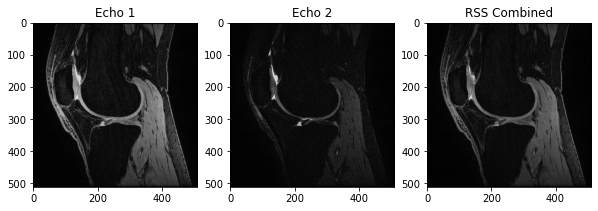

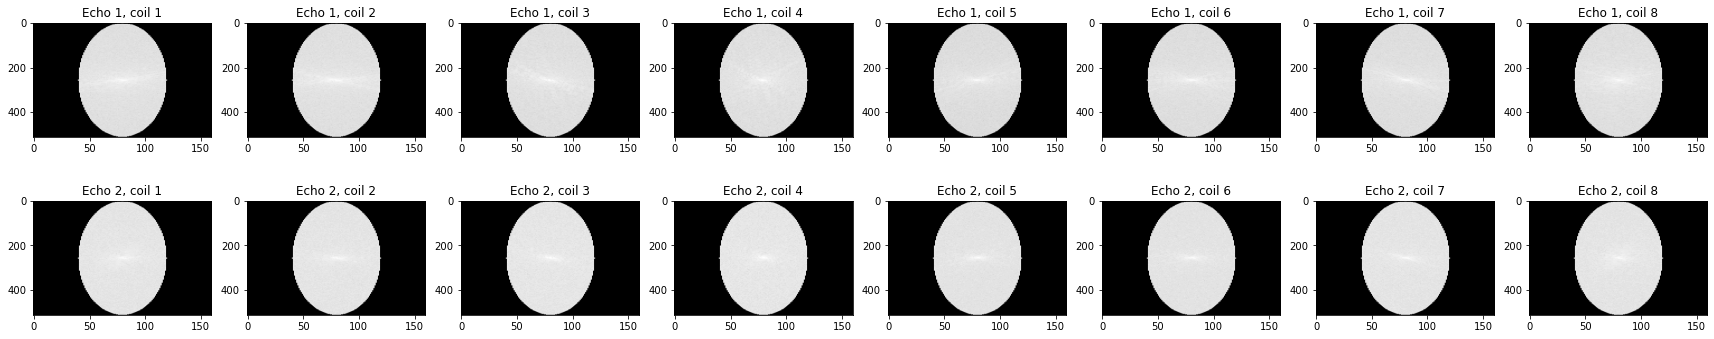

In [11]:
show_image_slice(hf, 100)
show_kspace_slice(hf, 100)

In [12]:
def display_sample_pattern(hd5file):
    masks = hd5file['masks']
    mask_names = list(masks.keys())
    masks = [masks[i] for i in mask_names]
    fig, axs = plt.subplots(nrows=1, ncols=len(masks), figsize=(20, 5))
    for i, (mask, mask_name) in enumerate(zip(masks, mask_names)):
        axs[i].imshow(mask, cmap='gray', aspect=0.2)
        axs[i].set_title(f'{mask_name}')
    fig.show()

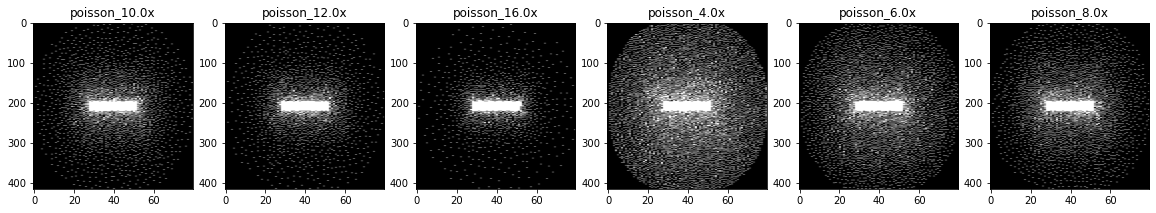

In [13]:
display_sample_pattern(hf)


In [14]:
import nibabel as nib

In [15]:
segmentation_mask_folder = "segmentation_masks/raw-data-track/"
segmentation_files = os.listdir(os.path.join(mri_data_root, segmentation_mask_folder))

In [16]:
def read_nii(file_path):
    nii = nib.load(file_path)
    return nii

(512, 512, 160)
[0 1 2 3 4 5 6]


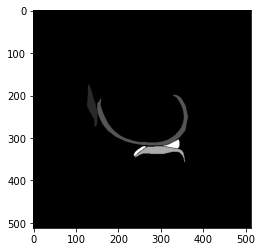

In [17]:
segmentation = np.array(read_nii(os.path.join(mri_data_root, segmentation_mask_folder, segmentation_files[0])).dataobj)

print(segmentation.shape)
print(np.unique(segmentation))
plt.imshow(segmentation[:, :, 50], cmap='gray')
plt.show()


In [18]:
from einops import rearrange

def read_mri_slice(fpath, slice, seq_len=1):
    mri = h5py.File(fpath)['target'][:, :, slice:slice+seq_len, 0, :]
    mri_image = np.abs(mri)
    mri_image = rearrange(mri_image, 'x y z e -> (z e) x y')
    return mri_image

from utils import convert_mask
def read_seg_mask(fpath, slice, seq_len=1):
    mask = read_nii(fpath).dataobj[:, :, slice:slice+seq_len]
    seg_mask = convert_mask(np.array(mask))
    seg_mask = rearrange(seg_mask, 'h w c s -> (c s) h w')
    return seg_mask


In [19]:
import pickle
with open('.cache/skm_cache.pkl', 'rb') as f:
    dataset_cache = pickle.load(f)
    mri_iter = dataset_cache[0]
    seg_iter = dataset_cache[1]

import random
rand_indices = random.sample(range(len(mri_iter)), len(mri_iter))
print(len(mri_iter), len(np.unique(rand_indices)))

24780 24780


In [20]:
%%timeit

for i in rand_indices[:100]:
    fname, slice_idx = mri_iter[i]
    mri = read_mri_slice(os.path.join(mri_data_root, subfolder, fname), slice_idx)

KeyboardInterrupt: 

In [65]:
%%timeit

for i in rand_indices[:100]:
    fname, slice_idx = seg_iter[i]
    seg = read_seg_mask(os.path.join(mri_data_root, segmentation_mask_folder, fname), slice_idx)

3.55 s ± 5.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Min: 2035.8126220703125, Mean: 5876501.0, Max: 50228072.0, Median: 2747060.5, STD: 7450640.0.


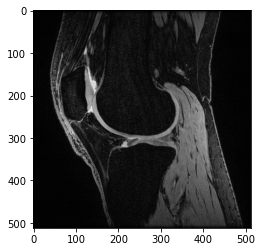

In [27]:
mri_scan = hf['target'][:, :, 100, 0, :]
print_stats(np.abs(mri_scan))
plt.imshow(np.abs(mri_scan), cmap="gray")